# Install Required Libraries

In [1]:
# Install kagglehub for downloading the dataset
!pip install -q kagglehub

kagglehub allows us to download datasets from Kaggle easily.

# Import All Required Libraries

In [2]:
import os                      # For file and directory operations
import numpy as np             # For numerical operations
import cv2                     # For image processing (reading, resizing)
import torch                   # PyTorch for creating tensors
import kagglehub              # For downloading dataset from Kaggle
from pathlib import Path       # For handling file paths elegantly
import glob                    # For finding files matching patterns
from tqdm import tqdm          # For progress bars
import random                  # For random operations
# from google.colab import drive # For mounting Google Drive

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+cu126
CUDA available: False


#  Set Random Seeds for Reproducibility

In [3]:
# Set random seeds so results are reproducible
RANDOM_SEED = 42

random.seed(RANDOM_SEED)           # Python's random module
np.random.seed(RANDOM_SEED)        # NumPy's random
torch.manual_seed(RANDOM_SEED)     # PyTorch CPU operations
torch.cuda.manual_seed(RANDOM_SEED) # PyTorch GPU operations

print(f"Random seed set to {RANDOM_SEED}")

Random seed set to 42


RANDOM_SEED = 42 - Sets our magic number (42 is a convention, any number works) <br>
random.seed(RANDOM_SEED) - Sets seed for Python's built-in random module <br>
np.random.seed(RANDOM_SEED) - Sets seed for NumPy's random operations <br>
torch.manual_seed(RANDOM_SEED) - Sets seed for PyTorch operations on CPU <br>
torch.cuda.manual_seed(RANDOM_SEED) - Sets seed for PyTorch operations on GPU <br>



# Configure Kaggle Credentials

In [4]:
# Set up Kaggle API credentials as environment variables
os.environ['KAGGLE_USERNAME'] = "mamaniaharsh7"
os.environ['KAGGLE_KEY'] = "874d22c6d4c17ee2a0b9095c121f2cdc"

---

# Define Configuration Parameters

In [5]:
# Configuration for our dataset creation
CONFIG = {
    'target_frames': 1000,        # Start with 1k frames for testing (will change to 100k later)
    'image_size': 64,             # Resize all images to 64x64
    'normalization': [0, 1],      # Normalize pixel values to [0, 1] range
    'dtype': torch.float32,       # Use float32 precision
    'label_real': 0,              # Label for real videos
    'label_fake': 1,              # Label for fake videos
}

Creates a dictionary called CONFIG that stores all our settings in one place <br>
'target_frames': 1000 - We'll start with 1,000 frames as a test <br>
'image_size': 64 - All images will be resized to 64×64 pixels <br>
'normalization': [0, 1] - Pixel values will be scaled from [0, 255] to [0, 1] <br>
'dtype': torch.float32 - Tensors will use 32-bit floating point precision <br>
'label_real': 0 - Real videos get label 0 <br>
'label_fake': 1 - Fake videos get label 1 <br>

---

# SECTION 2: Download FaceForensics++ Dataset

## Cell 2.1: Download Dataset from Kaggle

In [6]:
import time

# Start timer to measure download time
start_time = time.time()

# Download the dataset using kagglehub
path = kagglehub.dataset_download("xdxd003/ff-c23")

# Calculate elapsed time
elapsed_time = time.time() - start_time

print(f"\n✅ Download completed in {elapsed_time/60:.2f} minutes")
print(f"📁 Dataset location: {path}")

# Store the path for later use
DATASET_PATH = path

Using Colab cache for faster access to the 'ff-c23' dataset.

✅ Download completed in 0.03 minutes
📁 Dataset location: /kaggle/input/ff-c23


import time - Import time module to measure download duration <br>
start_time = time.time() - Record the current timestamp before download starts <br><br>
path = kagglehub.dataset_download("xdxd003/ff-c23") - Main download command <br>
Downloads the FaceForensics++ dataset (c23 compression) <br>
Returns the path where dataset is stored <br>
Kagglehub caches it so re-running won't re-download <br>
<br>
elapsed_time = time.time() - start_time - Calculate how long download took <br>
DATASET_PATH = path - Save the path in a variable we can use throughout the notebook <br>

## Cell 2.2: Explore Dataset Structure

In [7]:
# List all items in the dataset directory
print(f"\n📁 Contents of: {DATASET_PATH}")
items = sorted(os.listdir(DATASET_PATH))

for item in items:
    item_path = os.path.join(DATASET_PATH, item)
    if os.path.isdir(item_path):
        # Count files in this directory
        num_files = len(os.listdir(item_path))
        print(f"  📁 {item}/ ({num_files} files)")
    else:
        # Show file size
        size_mb = os.path.getsize(item_path) / (1024**2)
        print(f"  📄 {item} ({size_mb:.2f} MB)")


📁 Contents of: /kaggle/input/ff-c23
  📁 FaceForensics++_C23/ (8 files)


os.listdir(DATASET_PATH) - Gets list of all files/folders in the dataset directory <br>
sorted(...) - Sorts them alphabetically for easier reading <br>
for item in items: - Loop through each item <br>
item_path = os.path.join(DATASET_PATH, item) - Creates full path to the item <br>
os.path.isdir(item_path) - Checks if item is a directory (folder) <br>
len(os.listdir(item_path)) - Counts how many files are inside the folder <br>
os.path.getsize(item_path) - Gets file size in bytes <br>
/ (1024**2) - Converts bytes to megabytes (MB) <br>
<br>
Expected output: You'll see folders like:

original/ (1000 files) <br>
Deepfakes/ (1000 files) <br>
csv/ (10 files)<br>
And other manipulation folders <br>

## Cell 2.3: Locate Original and Deepfake Video Folders


In [9]:
# The dataset has an extra subfolder level
# Update the base path to include the FaceForensics++_C23 folder
DATASET_PATH = os.path.join(DATASET_PATH, "FaceForensics++_C23")

print(f"📁 Updated dataset path: {DATASET_PATH}")

# Now let's see what's inside
print(f"\n📂 Contents of FaceForensics++_C23:")
items = sorted(os.listdir(DATASET_PATH))
for item in items:
    item_path = os.path.join(DATASET_PATH, item)
    if os.path.isdir(item_path):
        num_files = len(os.listdir(item_path))
        print(f"  📁 {item}/ ({num_files} files)")

📁 Updated dataset path: /kaggle/input/ff-c23/FaceForensics++_C23

📂 Contents of FaceForensics++_C23:
  📁 DeepFakeDetection/ (1000 files)
  📁 Deepfakes/ (1000 files)
  📁 Face2Face/ (1000 files)
  📁 FaceShifter/ (1000 files)
  📁 FaceSwap/ (1000 files)
  📁 NeuralTextures/ (1000 files)
  📁 csv/ (10 files)
  📁 original/ (1000 files)


In [10]:
# Define paths to the two folders we need
original_folder = os.path.join(DATASET_PATH, "original")
deepfake_folder = os.path.join(DATASET_PATH, "Deepfakes")

# Get list of all video files in each folder
original_videos = sorted(glob.glob(os.path.join(original_folder, "*.mp4")))
deepfake_videos = sorted(glob.glob(os.path.join(deepfake_folder, "*.mp4")))

print(f"\n📊 Found {len(original_videos)} original videos")
print(f"📊 Found {len(deepfake_videos)} deepfake videos")
print(f"📊 Total videos: {len(original_videos) + len(deepfake_videos)}")

# Display sample video names
if len(original_videos) > 0:
    print(f"\n📝 Sample original videos:")
    for i, video in enumerate(original_videos[:3], 1):
        print(f"  {i}. {os.path.basename(video)}")

if len(deepfake_videos) > 0:
    print(f"\n📝 Sample deepfake videos:")
    for i, video in enumerate(deepfake_videos[:3], 1):
        print(f"  {i}. {os.path.basename(video)}")

# Verify we have the expected number
if len(original_videos) == 1000 and len(deepfake_videos) == 1000:
    print(f"\n✅ Perfect! Found all 2000 videos (1000 real + 1000 fake)")
else:
    print(f"\n⚠️ Warning: Expected 2000 videos total, found {len(original_videos) + len(deepfake_videos)}")


📊 Found 1000 original videos
📊 Found 1000 deepfake videos
📊 Total videos: 2000

📝 Sample original videos:
  1. 000.mp4
  2. 001.mp4
  3. 002.mp4

📝 Sample deepfake videos:
  1. 000_003.mp4
  2. 001_870.mp4
  3. 002_006.mp4

✅ Perfect! Found all 2000 videos (1000 real + 1000 fake)


os.path.join(DATASET_PATH, "original") - Creates the full path to the original videos folder <br>  <br>
glob.glob(os.path.join(original_folder, "*.mp4")) - Finds all files matching the pattern  <br>

"*.mp4" means "any file ending with .mp4"  <br>
Returns a list of full paths to all MP4 files  <br>
 <br>

sorted(...) - Sorts the video list alphabetically (important for reproducibility)  <br>
len(original_videos) - Counts how many videos we found  <br>
enumerate(original_videos[:3], 1) - Takes first 3 videos and numbers them starting from 1  <br>
os.path.basename(video) - Extracts just the filename (without the full path)  <br>
The verification at the end confirms we have exactly 1000 of each type  <br>

## Cell 2.4: Calculate Frames Needed Per Video


In [11]:
# Total frames we want
target_total_frames = CONFIG['target_frames']

# Split equally between real and fake
frames_per_category = target_total_frames // 2

# Calculate frames needed per video
num_original_videos = len(original_videos)
num_deepfake_videos = len(deepfake_videos)

frames_per_original_video = frames_per_category // num_original_videos
frames_per_deepfake_video = frames_per_category // num_deepfake_videos

print(f"🎯 Target: {target_total_frames:,} total frames")
print(f"   • {frames_per_category:,} from original videos")
print(f"   • {frames_per_category:,} from deepfake videos")
print(f"\n📊 Frame extraction plan:")
print(f"   • {frames_per_original_video} frames per original video (× {num_original_videos} videos)")
print(f"   • {frames_per_deepfake_video} frames per deepfake video (× {num_deepfake_videos} videos)")

# Calculate actual totals (accounting for integer division)
actual_original_frames = frames_per_original_video * num_original_videos
actual_deepfake_frames = frames_per_deepfake_video * num_deepfake_videos
actual_total = actual_original_frames + actual_deepfake_frames

print(f"\n✅ Actual frames we'll extract:")
print(f"   • Original: {actual_original_frames:,} frames")
print(f"   • Deepfake: {actual_deepfake_frames:,} frames")
print(f"   • Total: {actual_total:,} frames")

if actual_total != target_total_frames:
    print(f"\n⚠️ Note: {target_total_frames - actual_total} frames difference due to integer division")

🎯 Target: 1,000 total frames
   • 500 from original videos
   • 500 from deepfake videos

📊 Frame extraction plan:
   • 0 frames per original video (× 1000 videos)
   • 0 frames per deepfake video (× 1000 videos)

✅ Actual frames we'll extract:
   • Original: 0 frames
   • Deepfake: 0 frames
   • Total: 0 frames

⚠️ Note: 1000 frames difference due to integer division


target_total_frames = CONFIG['target_frames'] - Gets our target (1000 for test, 100k for full run) <br><br>
frames_per_category = target_total_frames // 2 - Splits equally (500 real + 500 fake for test)<br>

// is integer division (no decimals)
<br><br>

frames_per_original_video = frames_per_category // num_original_videos - Calculates frames per video<br>

For test: 500 ÷ 1000 = 0 frames per video (this is a problem for the test!)<br>
For full: 50,000 ÷ 1000 = 50 frames per video ✓<br>

<br><br>
actual_original_frames = frames_per_original_video * num_original_videos - Calculates actual total<br>

- Adjust Strategy for Small Test (IMPORTANT FIX)

In [12]:
# For small tests, we need to select a subset of videos
# For full run, we use all videos

if target_total_frames < len(original_videos) + len(deepfake_videos):
    # SMALL TEST MODE: Select subset of videos
    print("📌 Test mode: Selecting subset of videos")

    # Calculate how many videos we need to reach our target
    videos_per_category = max(1, target_total_frames // 100)  # At least 50 frames per video

    # Randomly select videos (using our seed for reproducibility)
    selected_original_videos = random.sample(original_videos, videos_per_category)
    selected_deepfake_videos = random.sample(deepfake_videos, videos_per_category)

    # Recalculate frames per video
    frames_per_original_video = frames_per_category // len(selected_original_videos)
    frames_per_deepfake_video = frames_per_category // len(selected_deepfake_videos)

    print(f"   ✓ Selected {len(selected_original_videos)} original videos")
    print(f"   ✓ Selected {len(selected_deepfake_videos)} deepfake videos")
    print(f"   ✓ Will extract ~{frames_per_original_video} frames per video")

else:
    # FULL MODE: Use all videos
    print("📌 Full mode: Using all videos")
    selected_original_videos = original_videos
    selected_deepfake_videos = deepfake_videos

    frames_per_original_video = frames_per_category // len(original_videos)
    frames_per_deepfake_video = frames_per_category // len(deepfake_videos)

    print(f"   ✓ Using all {len(original_videos)} original videos")
    print(f"   ✓ Using all {len(deepfake_videos)} deepfake videos")
    print(f"   ✓ Will extract {frames_per_original_video} frames per video")

print(f"\n✅ Final extraction plan:")
print(f"   Videos: {len(selected_original_videos)} original + {len(selected_deepfake_videos)} deepfake")
print(f"   Frames per video: ~{frames_per_original_video}")
print(f"   Target total: ~{target_total_frames:,} frames")

📌 Test mode: Selecting subset of videos
   ✓ Selected 10 original videos
   ✓ Selected 10 deepfake videos
   ✓ Will extract ~50 frames per video

✅ Final extraction plan:
   Videos: 10 original + 10 deepfake
   Frames per video: ~50
   Target total: ~1,000 frames


---

# SECTION 3: Frame Extraction

## Cell 3.1: Define Frame Extraction Function

In [13]:
def extract_frames_evenly(video_path, num_frames):
    """
    Extract evenly spaced frames from a video.

    Args:
        video_path (str): Path to the video file
        num_frames (int): Number of frames to extract

    Returns:
        list: List of numpy arrays (frames in BGR format)
    """
    frames = []  # Store extracted frames here

    try:
        # Open the video file
        cap = cv2.VideoCapture(video_path)

        # Get total number of frames in the video
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Check if video opened successfully
        if total_frames == 0:
            print(f"⚠️ Warning: Could not read {os.path.basename(video_path)}")
            cap.release()
            return frames

        # Calculate which frame indices to extract (evenly spaced)
        # np.linspace creates evenly spaced numbers
        # Example: if total_frames=300 and num_frames=10
        # This gives: [0, 33, 66, 99, 133, 166, 199, 233, 266, 299]
        frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

        # Extract each frame
        for frame_idx in frame_indices:
            # Jump to the specific frame
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

            # Read the frame
            ret, frame = cap.read()

            # Check if frame was read successfully
            if ret:
                # Convert from BGR (OpenCV format) to RGB (standard format)
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame_rgb)
            else:
                print(f"⚠️ Failed to read frame {frame_idx} from {os.path.basename(video_path)}")

        # Release the video file
        cap.release()

    except Exception as e:
        # Catch any errors during processing
        print(f"❌ Error processing {os.path.basename(video_path)}: {str(e)}")

    return frames

✅ Frame extraction function defined!


def extract_frames_evenly(video_path, num_frames): - Defines a function that takes video path and desired frame count
frames = [] - Creates empty list to store extracted frames

Open video:

cap = cv2.VideoCapture(video_path) - Opens the video file using OpenCV
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - Gets total number of frames in the video
if total_frames == 0: - Checks if video is corrupted or unreadable

Calculate frame positions:

frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int) - Key line!

Creates evenly spaced frame indices
Example: For 300-frame video wanting 10 frames → [0, 33, 66, 99, 133, 166, 199, 233, 266, 299]
dtype=int ensures we get whole numbers (can't extract frame 33.5)



Extract frames:

for frame_idx in frame_indices: - Loop through each frame index we calculated
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx) - Jumps video to specific frame number
ret, frame = cap.read() - Reads that frame

ret is True/False (success/failure)
frame is the actual image as numpy array


cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) - Converts color format

OpenCV reads images in BGR (Blue-Green-Red)
We need RGB (Red-Green-Blue) - standard format


frames.append(frame_rgb) - Adds frame to our list

Cleanup:

cap.release() - Closes the video file (important to free memory!)
except Exception as e: - Catches any errors so one bad video doesn't crash everything

## Cell 3.2: Extract Frames from Original Videos


In [14]:
# Storage for all frames
original_frames = []

# Use tqdm for progress bar
for video_path in tqdm(selected_original_videos, desc="Processing original videos"):
    # Extract frames from this video
    frames = extract_frames_evenly(video_path, frames_per_original_video)

    # Add all extracted frames to our collection
    original_frames.extend(frames)

print(f"\n✅ Extracted {len(original_frames)} frames from {len(selected_original_videos)} original videos")
print(f"   Average: {len(original_frames) / len(selected_original_videos):.1f} frames per video")

# Check first frame properties
if len(original_frames) > 0:
    sample_frame = original_frames[0]
    print(f"\n🖼️ Sample frame properties:")
    print(f"   Shape: {sample_frame.shape} (Height × Width × Channels)")
    print(f"   Data type: {sample_frame.dtype}")
    print(f"   Value range: [{sample_frame.min()}, {sample_frame.max()}]")

Processing original videos: 100%|██████████| 10/10 [04:31<00:00, 27.12s/it]


✅ Extracted 500 frames from 10 original videos
   Average: 50.0 frames per video

🖼️ Sample frame properties:
   Shape: (480, 640, 3) (Height × Width × Channels)
   Data type: uint8
   Value range: [0, 255]


original_frames = [] - Creates empty list to store ALL frames from ALL original videos
for video_path in tqdm(selected_original_videos, desc="..."): - Loop through each video

tqdm() wraps the loop to show a progress bar
desc="..." sets the progress bar description


frames = extract_frames_evenly(video_path, frames_per_original_video) - Extracts frames from one video

Uses our function from Cell 3.1
frames_per_original_video was calculated in Section 2 (~50 for test, 50 for full)


original_frames.extend(frames) - Adds frames to our collection

.extend() adds all items from frames list to original_frames list
Different from .append() which would add the entire list as one item


len(original_frames) - Counts total frames extracted
sample_frame.shape - Shows dimensions (e.g., (720, 1280, 3) = 720 height × 1280 width × 3 color channels)
sample_frame.dtype - Shows data type (e.g., uint8 = unsigned 8-bit integer, values 0-255)
sample_frame.min() and .max() - Shows value range (should be 0-255 for raw images)

## Cell 3.3: Extract Frames from Deepfake Videos


In [15]:
# Storage for all frames
deepfake_frames = []

# Use tqdm for progress bar
for video_path in tqdm(selected_deepfake_videos, desc="Processing deepfake videos"):
    # Extract frames from this video
    frames = extract_frames_evenly(video_path, frames_per_deepfake_video)

    # Add all extracted frames to our collection
    deepfake_frames.extend(frames)

print(f"\n✅ Extracted {len(deepfake_frames)} frames from {len(selected_deepfake_videos)} deepfake videos")
print(f"   Average: {len(deepfake_frames) / len(selected_deepfake_videos):.1f} frames per video")

# Check first frame properties
if len(deepfake_frames) > 0:
    sample_frame = deepfake_frames[0]
    print(f"\n🖼️ Sample frame properties:")
    print(f"   Shape: {sample_frame.shape} (Height × Width × Channels)")
    print(f"   Data type: {sample_frame.dtype}")
    print(f"   Value range: [{sample_frame.min()}, {sample_frame.max()}]")

Processing deepfake videos: 100%|██████████| 10/10 [04:58<00:00, 29.88s/it]


✅ Extracted 500 frames from 10 deepfake videos
   Average: 50.0 frames per video

🖼️ Sample frame properties:
   Shape: (720, 1280, 3) (Height × Width × Channels)
   Data type: uint8
   Value range: [0, 255]


Exactly the same as Cell 3.2, but for deepfake videos instead of original videos
deepfake_frames = [] - Separate list for fake video frames
Everything else follows the same pattern

## Cell 3.4: Summary of Frame Extraction

In [16]:
total_frames = len(original_frames) + len(deepfake_frames)

print(f"✅ Total frames extracted: {total_frames:,}")
print(f"   • Original (real): {len(original_frames):,} frames")
print(f"   • Deepfake (fake): {len(deepfake_frames):,} frames")

# Calculate balance
balance_ratio = len(original_frames) / len(deepfake_frames) if len(deepfake_frames) > 0 else 0
print(f"\n⚖️ Dataset balance: {balance_ratio:.3f}:1 (real:fake)")

if 0.95 <= balance_ratio <= 1.05:
    print("   ✅ Perfectly balanced!")
elif 0.90 <= balance_ratio <= 1.10:
    print("   ✅ Well balanced")
else:
    print("   ⚠️ Slight imbalance detected")

# Memory estimate
bytes_per_frame = original_frames[0].nbytes if len(original_frames) > 0 else 0
total_memory_mb = (total_frames * bytes_per_frame) / (1024**2)

print(f"\n💾 Current memory usage:")
print(f"   • Bytes per frame: {bytes_per_frame:,} bytes")
print(f"   • Total raw frames: {total_memory_mb:.2f} MB")
print(f"   • After processing (64×64): ~{total_frames * 64 * 64 * 3 / (1024**2):.2f} MB")

print(f"\n✅ Ready for image processing and tensor creation!")

✅ Total frames extracted: 1,000
   • Original (real): 500 frames
   • Deepfake (fake): 500 frames

⚖️ Dataset balance: 1.000:1 (real:fake)
   ✅ Perfectly balanced!

💾 Current memory usage:
   • Bytes per frame: 921,600 bytes
   • Total raw frames: 878.91 MB
   • After processing (64×64): ~11.72 MB

✅ Ready for image processing and tensor creation!


total_frames = len(original_frames) + len(deepfake_frames) - Counts all frames
balance_ratio = len(original_frames) / len(deepfake_frames) - Calculates balance

Perfect balance = 1.0 (equal amounts)


1.0 = more real frames


< 1.0 = more fake frames


original_frames[0].nbytes - Gets memory size of one frame in bytes

.nbytes is a numpy array property showing total bytes


(total_frames * bytes_per_frame) / (1024**2) - Converts to megabytes

Divide by 1024 once = KB, twice = MB

- Sample:

🖼️ VISUALIZING FRAME AND NUMPY ARRAY

📊 Numpy Array Properties:
   Shape: (480, 640, 3)
   Data type: uint8
   Min value: 0
   Max value: 255
   Memory size: 921,600 bytes (0.88 MB)

📐 Dimensions:
   Height: 480 pixels
   Width: 640 pixels
   Channels: 3 (Red, Green, Blue)
   Total pixels: 307,200

🔍 Sample 3×3 pixels from top-left corner:
   (Each pixel has 3 values: [R, G, B])

[[[0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]]]

💡 Interpretation:
   • Each number represents color intensity (0-255)
   • 0 = darkest (black), 255 = brightest (white)
   • Each pixel has [R, G, B] values
   • Example: [255, 0, 0] = pure red
   • Example: [0, 255, 0] = pure green
   • Example: [255, 255, 255] = white

📈 Channel Statistics:
   Red channel   - Mean: 16.73, Std: 41.13
   Green channel - Mean: 36.33, Std: 49.43
   Blue channel  - Mean: 91.79, Std: 62.62


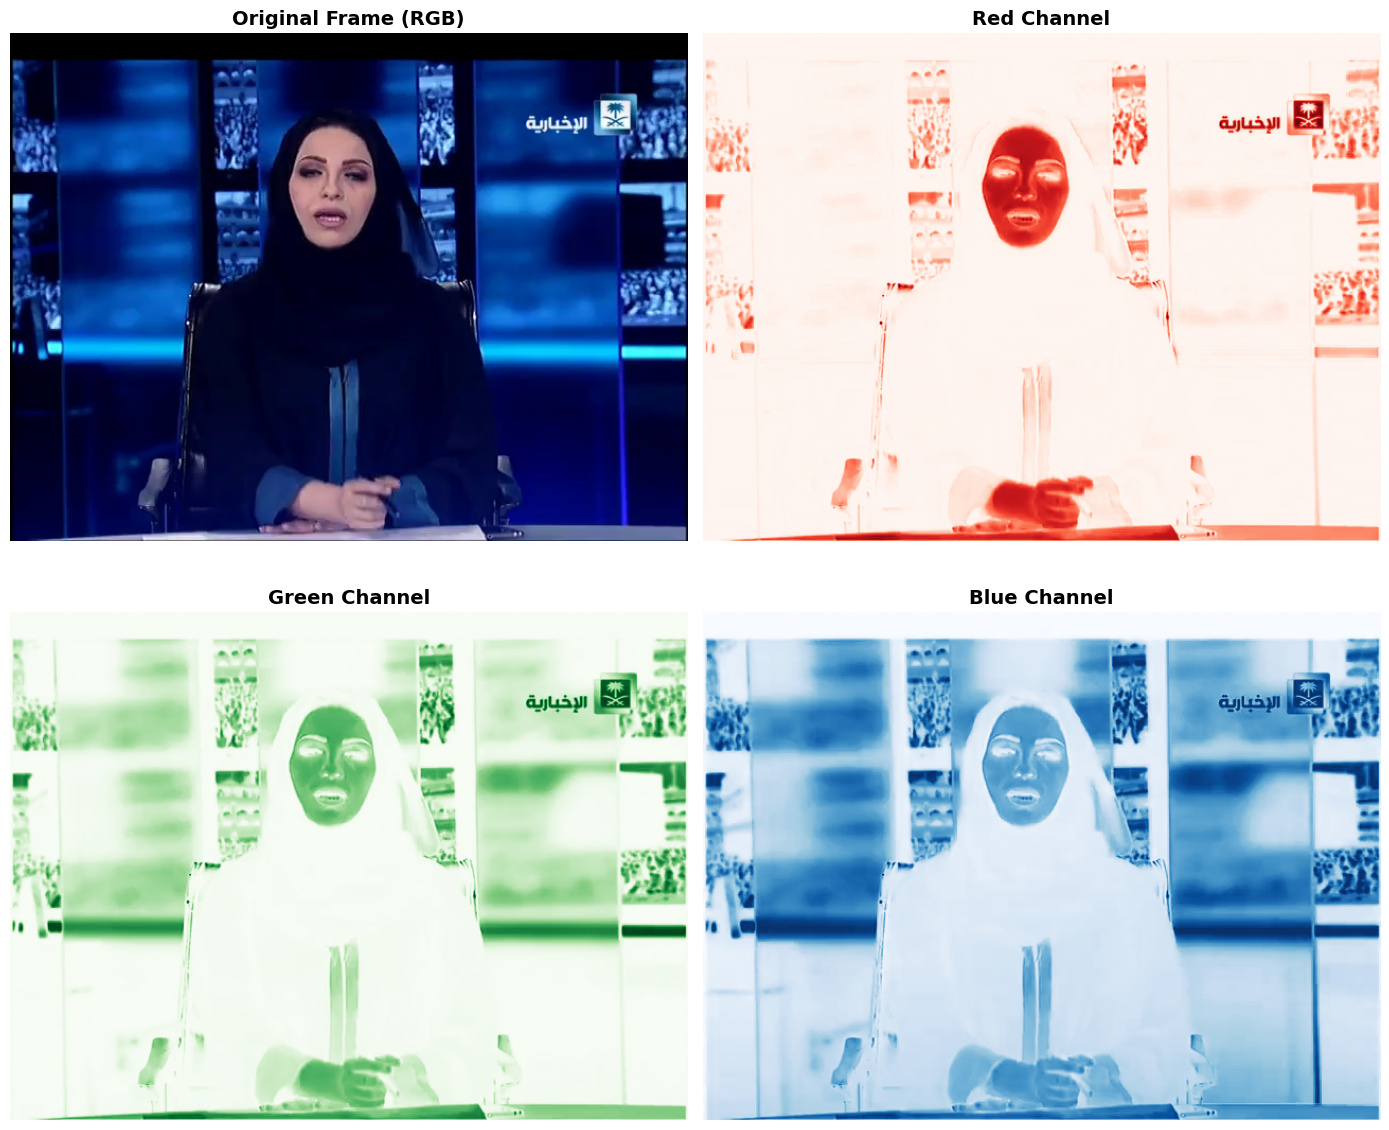


🔎 Zoomed view: 10×10 pixels from center with values


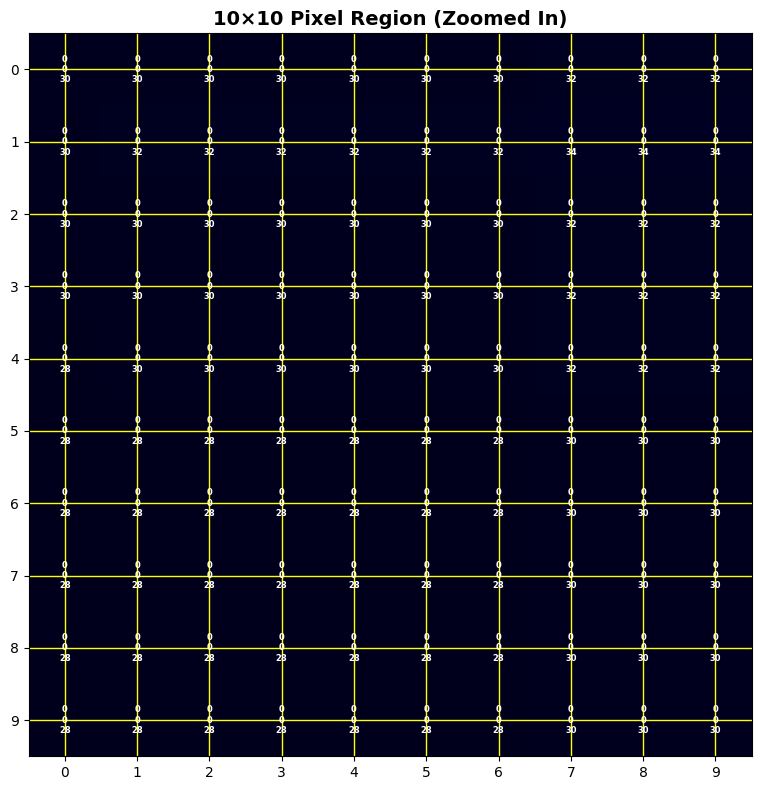


✅ Frame visualization complete!

💭 Key Takeaway:
   The numpy array is just a 3D grid of numbers representing
   color intensities at each pixel location!


In [17]:
import matplotlib.pyplot as plt

print("🖼️ VISUALIZING FRAME AND NUMPY ARRAY")
print("="*60)

# Select a sample frame (let's take the first original frame)
sample_frame = original_frames[0]

print("\n📊 Numpy Array Properties:")
print(f"   Shape: {sample_frame.shape}")
print(f"   Data type: {sample_frame.dtype}")
print(f"   Min value: {sample_frame.min()}")
print(f"   Max value: {sample_frame.max()}")
print(f"   Memory size: {sample_frame.nbytes:,} bytes ({sample_frame.nbytes / (1024**2):.2f} MB)")

# Break down the shape
height, width, channels = sample_frame.shape
print(f"\n📐 Dimensions:")
print(f"   Height: {height} pixels")
print(f"   Width: {width} pixels")
print(f"   Channels: {channels} (Red, Green, Blue)")
print(f"   Total pixels: {height * width:,}")

# Show a small slice of the array (top-left corner, 3x3 pixels)
print(f"\n🔍 Sample 3×3 pixels from top-left corner:")
print(f"   (Each pixel has 3 values: [R, G, B])")
print(f"\n{sample_frame[:3, :3, :]}")

# Explain what we're seeing
print(f"\n💡 Interpretation:")
print(f"   • Each number represents color intensity (0-255)")
print(f"   • 0 = darkest (black), 255 = brightest (white)")
print(f"   • Each pixel has [R, G, B] values")
print(f"   • Example: [255, 0, 0] = pure red")
print(f"   • Example: [0, 255, 0] = pure green")
print(f"   • Example: [255, 255, 255] = white")

# Show statistics for each channel
print(f"\n📈 Channel Statistics:")
red_channel = sample_frame[:, :, 0]
green_channel = sample_frame[:, :, 1]
blue_channel = sample_frame[:, :, 2]

print(f"   Red channel   - Mean: {red_channel.mean():.2f}, Std: {red_channel.std():.2f}")
print(f"   Green channel - Mean: {green_channel.mean():.2f}, Std: {green_channel.std():.2f}")
print(f"   Blue channel  - Mean: {blue_channel.mean():.2f}, Std: {blue_channel.std():.2f}")

# Visualize the frame
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Full RGB image
axes[0, 0].imshow(sample_frame)
axes[0, 0].set_title('Original Frame (RGB)', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# 2. Red channel only
axes[0, 1].imshow(sample_frame[:, :, 0], cmap='Reds')
axes[0, 1].set_title('Red Channel', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# 3. Green channel only
axes[1, 0].imshow(sample_frame[:, :, 1], cmap='Greens')
axes[1, 0].set_title('Green Channel', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

# 4. Blue channel only
axes[1, 1].imshow(sample_frame[:, :, 2], cmap='Blues')
axes[1, 1].set_title('Blue Channel', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Show a zoomed-in section with pixel values
print("\n🔎 Zoomed view: 10×10 pixels from center with values")
center_y = height // 2
center_x = width // 2

# Extract small region
small_region = sample_frame[center_y:center_y+10, center_x:center_x+10, :]

# Create visualization
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(small_region)
ax.set_title('10×10 Pixel Region (Zoomed In)', fontsize=14, fontweight='bold')

# Annotate each pixel with its RGB values
for i in range(10):
    for j in range(10):
        r, g, b = small_region[i, j, :]
        # Show RGB values on the image
        text_color = 'white' if (r + g + b) / 3 < 128 else 'black'
        ax.text(j, i, f'{r}\n{g}\n{b}',
                ha='center', va='center',
                color=text_color, fontsize=6,
                fontweight='bold')

ax.set_xticks(range(10))
ax.set_yticks(range(10))
ax.grid(True, color='yellow', linewidth=1)
plt.tight_layout()
plt.show()

print("\n✅ Frame visualization complete!")
print("\n💭 Key Takeaway:")
print("   The numpy array is just a 3D grid of numbers representing")
print("   color intensities at each pixel location!")

^top left ==> black pixel

In [18]:
# Let's look at the CENTER of the frame instead of corner
sample_frame = original_frames[0]
height, width, channels = sample_frame.shape
center_y = height // 2
center_x = width // 2

print("🔍 CENTER 3×3 pixels (where face likely is):")
center_region = sample_frame[center_y:center_y+3, center_x:center_x+3, :]
print(center_region)

print(f"\n💡 Center pixel RGB value: {sample_frame[center_y, center_x, :]}")
print(f"   This should NOT be [0, 0, 0] if face is present!")

# Count black pixels
black_pixels = np.sum(np.all(sample_frame == 0, axis=2))
total_pixels = height * width
percent_black = (black_pixels / total_pixels) * 100

print(f"\n📊 Black pixel analysis:")
print(f"   Total black pixels: {black_pixels:,} / {total_pixels:,}")
print(f"   Percentage black: {percent_black:.2f}%")

if percent_black > 50:
    print("   ⚠️ This frame is mostly letterbox/padding")
elif percent_black > 20:
    print("   ⚠️ Frame has significant letterboxing")
else:
    print("   ✅ Frame has minimal letterboxing")

🔍 CENTER 3×3 pixels (where face likely is):
[[[ 0  0 30]
  [ 0  0 30]
  [ 0  0 30]]

 [[ 0  0 30]
  [ 0  0 32]
  [ 0  0 32]]

 [[ 0  0 30]
  [ 0  0 30]
  [ 0  0 30]]]

💡 Center pixel RGB value: [ 0  0 30]
   This should NOT be [0, 0, 0] if face is present!

📊 Black pixel analysis:
   Total black pixels: 14,736 / 307,200
   Percentage black: 4.80%
   ✅ Frame has minimal letterboxing


---

# SECTION 4: Image Processing & Tensor Creation

We'll take all the extracted frames, resize them to 64×64, normalize pixel values to [0, 1], convert from numpy arrays to PyTorch tensors, and create our final dataset tensors with proper shape (N, 3, 64, 64).

## Cell 4.1: Resize All Frames to 64×64

In [19]:
target_size = CONFIG['image_size']  # 64
print(f"Target size: {target_size}×{target_size} pixels")

# Function to resize a single frame
def resize_frame(frame, size):
    """
    Resize a frame to target size.

    Args:
        frame (numpy.ndarray): Input frame (H, W, C)
        size (int): Target size (will be size × size)

    Returns:
        numpy.ndarray: Resized frame
    """
    # cv2.resize takes (width, height) - note the order!
    resized = cv2.resize(frame, (size, size), interpolation=cv2.INTER_AREA)
    return resized

# Resize all original frames
print(f"\n📐 Resizing {len(original_frames)} original frames...")
original_frames_resized = []

for frame in tqdm(original_frames, desc="Resizing original frames"):
    resized = resize_frame(frame, target_size)
    original_frames_resized.append(resized)

print(f"✅ Original frames resized: {len(original_frames_resized)}")

# Resize all deepfake frames
print(f"\n📐 Resizing {len(deepfake_frames)} deepfake frames...")
deepfake_frames_resized = []

for frame in tqdm(deepfake_frames, desc="Resizing deepfake frames"):
    resized = resize_frame(frame, target_size)
    deepfake_frames_resized.append(resized)

print(f"✅ Deepfake frames resized: {len(deepfake_frames_resized)}")

# Verify the new size
if len(original_frames_resized) > 0:
    sample = original_frames_resized[0]
    print(f"\n🖼️ Resized frame properties:")
    print(f"   Shape: {sample.shape} (was {original_frames[0].shape})")
    print(f"   Size reduction: {original_frames[0].nbytes / sample.nbytes:.1f}x smaller")
    print(f"   Memory per frame: {sample.nbytes:,} bytes")

total_memory = (len(original_frames_resized) + len(deepfake_frames_resized)) * sample.nbytes / (1024**2)
print(f"\n💾 Total memory for resized frames: {total_memory:.2f} MB")

Target size: 64×64 pixels

📐 Resizing 500 original frames...


Resizing original frames: 100%|██████████| 500/500 [00:02<00:00, 226.84it/s]


✅ Original frames resized: 500

📐 Resizing 500 deepfake frames...


Resizing deepfake frames: 100%|██████████| 500/500 [00:01<00:00, 258.99it/s]

✅ Deepfake frames resized: 500

🖼️ Resized frame properties:
   Shape: (64, 64, 3) (was (480, 640, 3))
   Size reduction: 75.0x smaller
   Memory per frame: 12,288 bytes

💾 Total memory for resized frames: 11.72 MB


def resize_frame(frame, size): - Creates reusable function for resizing
cv2.resize(frame, (size, size), interpolation=cv2.INTER_AREA) - Resizes the image

(size, size) = target dimensions (64, 64)
interpolation=cv2.INTER_AREA = method for resizing (best for downsampling)
Note: OpenCV takes (width, height), not (height, width)!



Resizing original frames:

original_frames_resized = [] - New list for resized frames
for frame in tqdm(original_frames, ...): - Loop through each frame with progress bar
resized = resize_frame(frame, target_size) - Resize to 64×64
original_frames_resized.append(resized) - Add to new list

Same process for deepfake frames
Verification:

sample.shape - Shows new shape should be (64, 64, 3)
original_frames[0].nbytes / sample.nbytes - Shows how much smaller (e.g., 400x)
Calculates total memory used

## Cell 4.2: Normalize Pixel Values to [0, 1]


In [20]:
original_frames_normalized = []

for frame in tqdm(original_frames_resized, desc="Normalizing original frames"):
    # Convert from uint8 [0, 255] to float32 [0, 1]
    normalized = frame.astype(np.float32) / 255.0
    original_frames_normalized.append(normalized)

print(f"✅ Original frames normalized: {len(original_frames_normalized)}")

# Normalize all deepfake frames
print(f"\n📊 Normalizing {len(deepfake_frames_resized)} deepfake frames...")
deepfake_frames_normalized = []

for frame in tqdm(deepfake_frames_resized, desc="Normalizing deepfake frames"):
    # Convert from uint8 [0, 255] to float32 [0, 1]
    normalized = frame.astype(np.float32) / 255.0
    deepfake_frames_normalized.append(normalized)

print(f"✅ Deepfake frames normalized: {len(deepfake_frames_normalized)}")

# Verify normalization
if len(original_frames_normalized) > 0:
    sample = original_frames_normalized[0]
    print(f"\n🔍 Normalized frame properties:")
    print(f"   Data type: {sample.dtype} (was uint8)")
    print(f"   Value range: [{sample.min():.6f}, {sample.max():.6f}] (was [0, 255])")
    print(f"   Mean value: {sample.mean():.6f}")
    print(f"   Shape: {sample.shape} (unchanged)")

# Memory comparison
original_memory = original_frames_resized[0].nbytes
normalized_memory = sample.nbytes
print(f"\n💾 Memory comparison:")
print(f"   Before (uint8): {original_memory:,} bytes per frame")
print(f"   After (float32): {normalized_memory:,} bytes per frame")
print(f"   Increase: {normalized_memory / original_memory:.1f}x (expected: 4x)")

Normalizing original frames: 100%|██████████| 500/500 [00:00<00:00, 29151.81it/s]


✅ Original frames normalized: 500

📊 Normalizing 500 deepfake frames...


Normalizing deepfake frames: 100%|██████████| 500/500 [00:00<00:00, 23962.25it/s]

✅ Deepfake frames normalized: 500

🔍 Normalized frame properties:
   Data type: float32 (was uint8)
   Value range: [0.000000, 0.988235] (was [0, 255])
   Mean value: 0.189318
   Shape: (64, 64, 3) (unchanged)

💾 Memory comparison:
   Before (uint8): 12,288 bytes per frame
   After (float32): 49,152 bytes per frame
   Increase: 4.0x (expected: 4x)


frame.astype(np.float32) - Converts data type from uint8 to float32

uint8: 1 byte per value, range [0, 255]
float32: 4 bytes per value, can hold decimals


/ 255.0 - Divides by 255 to scale to [0, 1] range

Example: 0 → 0.0, 127 → 0.498, 255 → 1.0


The loop does this for every frame

Why float32 instead of float64?

float32 uses 4 bytes (sufficient precision for images)
float64 uses 8 bytes (overkill, wastes memory)

Verification:

sample.min() and sample.max() - Should be between 0.0 and 1.0
Memory increases 4x because float32 is 4 bytes vs uint8's 1 byte

## Cell 4.3: Convert to PyTorch Tensors (Channel-First Format)

In [21]:
print("📌 Converting from (H, W, C) to (C, H, W) format...")
print("   NumPy format: (Height, Width, Channels) - e.g., (64, 64, 3)")
print("   PyTorch format: (Channels, Height, Width) - e.g., (3, 64, 64)")

# Function to convert numpy array to PyTorch tensor
def numpy_to_tensor(frame):
    """
    Convert numpy frame from (H, W, C) to PyTorch tensor (C, H, W).

    Args:
        frame (numpy.ndarray): Frame in shape (H, W, C)

    Returns:
        torch.Tensor: Tensor in shape (C, H, W)
    """
    # Transpose from (H, W, C) to (C, H, W)
    # np.transpose reorders the dimensions
    # (0, 1, 2) → (2, 0, 1) means: dimension 2 becomes first, then 0, then 1
    frame_chw = np.transpose(frame, (2, 0, 1))

    # Convert to PyTorch tensor
    tensor = torch.from_numpy(frame_chw)

    return tensor

# Convert all original frames
print(f"\n🔄 Converting {len(original_frames_normalized)} original frames to tensors...")
original_tensors = []

for frame in tqdm(original_frames_normalized, desc="Converting original to tensors"):
    tensor = numpy_to_tensor(frame)
    original_tensors.append(tensor)

print(f"✅ Original tensors created: {len(original_tensors)}")

# Convert all deepfake frames
print(f"\n🔄 Converting {len(deepfake_frames_normalized)} deepfake frames to tensors...")
deepfake_tensors = []

for frame in tqdm(deepfake_frames_normalized, desc="Converting deepfake to tensors"):
    tensor = numpy_to_tensor(frame)
    deepfake_tensors.append(tensor)

print(f"✅ Deepfake tensors created: {len(deepfake_tensors)}")

# Verify conversion
if len(original_tensors) > 0:
    sample = original_tensors[0]
    print(f"\n🔍 Tensor properties:")
    print(f"   Shape: {sample.shape} (C, H, W)")
    print(f"   Data type: {sample.dtype}")
    print(f"   Device: {sample.device} (cpu)")
    print(f"   Value range: [{sample.min():.6f}, {sample.max():.6f}]")
    print(f"   Is contiguous: {sample.is_contiguous()}")

# Memory check
print(f"\n💾 Memory per tensor: {sample.element_size() * sample.nelement():,} bytes")

📌 Converting from (H, W, C) to (C, H, W) format...
   NumPy format: (Height, Width, Channels) - e.g., (64, 64, 3)
   PyTorch format: (Channels, Height, Width) - e.g., (3, 64, 64)

🔄 Converting 500 original frames to tensors...


Converting original to tensors: 100%|██████████| 500/500 [00:00<00:00, 22420.32it/s]


✅ Original tensors created: 500

🔄 Converting 500 deepfake frames to tensors...


Converting deepfake to tensors: 100%|██████████| 500/500 [00:00<00:00, 161356.62it/s]

✅ Deepfake tensors created: 500

🔍 Tensor properties:
   Shape: torch.Size([3, 64, 64]) (C, H, W)
   Data type: torch.float32
   Device: cpu (cpu)
   Value range: [0.000000, 0.988235]
   Is contiguous: False

💾 Memory per tensor: 49,152 bytes


The transpose operation:

np.transpose(frame, (2, 0, 1)) - Rearranges dimensions

Input: (64, 64, 3) where indices are (0, 1, 2)
Output: (3, 64, 64) by moving dimension 2 to position 0
Visual example:



    Before: frame[height, width, channel]
    After:  frame[channel, height, width]
Why this matters:

NumPy/OpenCV convention: (H, W, C) - "height first"
PyTorch convention: (C, H, W) - "channels first"
PyTorch CNNs expect (C, H, W) format!

Conversion:

torch.from_numpy(frame_chw) - Creates PyTorch tensor from numpy array

Shares memory (efficient, no copying)
Preserves data type (float32)



Verification:

sample.shape - Should be (3, 64, 64)
sample.device - Shows 'cpu' (we're not using GPU yet)
sample.is_contiguous() - Should be True (memory layout is optimal)

^Contiguous: False

## Cell 4.3 - UPDATED (Add .contiguous())


Since we're about to save these tensors to disk, let's add .contiguous() in Cell 4.4 after creating the final X tensor

## Cell 4.4: Stack All Tensors and Create Labels (UPDATED)

In [22]:
# Stack all original tensors into one large tensor
print(f"\n📚 Stacking {len(original_tensors)} original tensors...")
X_original = torch.stack(original_tensors)

print(f"✅ X_original shape: {X_original.shape}")
print(f"   Interpretation: ({X_original.shape[0]} images, {X_original.shape[1]} channels, {X_original.shape[2]}×{X_original.shape[3]} pixels)")

# Stack all deepfake tensors into one large tensor
print(f"\n📚 Stacking {len(deepfake_tensors)} deepfake tensors...")
X_deepfake = torch.stack(deepfake_tensors)

print(f"✅ X_deepfake shape: {X_deepfake.shape}")
print(f"   Interpretation: ({X_deepfake.shape[0]} images, {X_deepfake.shape[1]} channels, {X_deepfake.shape[2]}×{X_deepfake.shape[3]} pixels)")

# Combine both into final dataset tensor
print(f"\n🔗 Combining original and deepfake tensors...")
X = torch.cat([X_original, X_deepfake], dim=0)

# Make tensor contiguous in memory (ADDED)
print(f"🔧 Making tensor contiguous in memory...")
X = X.contiguous()

print(f"✅ Final X tensor shape: {X.shape}")
print(f"   Total images: {X.shape[0]:,}")
print(f"   Is contiguous: {X.is_contiguous()}")  # Should now be True

# Create labels
print(f"\n🏷️ Creating labels...")
# Labels for original frames (0 = real)
y_original = torch.zeros(len(original_tensors), dtype=torch.long)
# Labels for deepfake frames (1 = fake)
y_deepfake = torch.ones(len(deepfake_tensors), dtype=torch.long)

# Combine labels
y = torch.cat([y_original, y_deepfake], dim=0)

print(f"✅ Labels tensor shape: {y.shape}")
print(f"   Data type: {y.dtype}")
print(f"   Unique labels: {torch.unique(y).tolist()}")
print(f"   Label counts:")
print(f"      - Real (0): {(y == 0).sum().item()}")
print(f"      - Fake (1): {(y == 1).sum().item()}")

# Final verification
print(f"\n✅ DATASET CREATION COMPLETE!")
print(f"="*60)
print(f"📊 Final Dataset:")
print(f"   X shape: {X.shape} (images)")
print(f"   y shape: {y.shape} (labels)")
print(f"   X dtype: {X.dtype}")
print(f"   y dtype: {y.dtype}")
print(f"   X value range: [{X.min():.6f}, {X.max():.6f}]")
print(f"   y value range: [{y.min()}, {y.max()}]")
print(f"   X is contiguous: {X.is_contiguous()}")  # Verification
print(f"   y is contiguous: {y.is_contiguous()}")  # y should already be contiguous

# Memory usage
X_memory_mb = (X.element_size() * X.nelement()) / (1024**2)
y_memory_mb = (y.element_size() * y.nelement()) / (1024**2)
total_memory_mb = X_memory_mb + y_memory_mb

print(f"\n💾 Memory Usage:")
print(f"   X tensor: {X_memory_mb:.2f} MB")
print(f"   y tensor: {y_memory_mb:.2f} MB")
print(f"   Total: {total_memory_mb:.2f} MB")


📦 STACKING TENSORS AND CREATING LABELS

📚 Stacking 500 original tensors...
✅ X_original shape: torch.Size([500, 3, 64, 64])
   Interpretation: (500 images, 3 channels, 64×64 pixels)

📚 Stacking 500 deepfake tensors...
✅ X_deepfake shape: torch.Size([500, 3, 64, 64])
   Interpretation: (500 images, 3 channels, 64×64 pixels)

🔗 Combining original and deepfake tensors...
🔧 Making tensor contiguous in memory...
✅ Final X tensor shape: torch.Size([1000, 3, 64, 64])
   Total images: 1,000
   Is contiguous: True

🏷️ Creating labels...
✅ Labels tensor shape: torch.Size([1000])
   Data type: torch.int64
   Unique labels: [0, 1]
   Label counts:
      - Real (0): 500
      - Fake (1): 500

✅ DATASET CREATION COMPLETE!
📊 Final Dataset:
   X shape: torch.Size([1000, 3, 64, 64]) (images)
   y shape: torch.Size([1000]) (labels)
   X dtype: torch.float32
   y dtype: torch.int64
   X value range: [0.000000, 1.000000]
   y value range: [0, 1]
   X is contiguous: True
   y is contiguous: True

💾 Memory

Stacking tensors:

torch.stack(original_tensors) - Combines list of tensors into one tensor

Input: List of 500 tensors, each (3, 64, 64)
Output: One tensor of shape (500, 3, 64, 64)
Adds a new dimension at the beginning (batch dimension)



Concatenating:

torch.cat([X_original, X_deepfake], dim=0) - Joins tensors along dimension 0

X_original: (500, 3, 64, 64)
X_deepfake: (500, 3, 64, 64)
Result: (1000, 3, 64, 64)
dim=0 means "stack along first dimension"



Creating labels:

torch.zeros(len(original_tensors), dtype=torch.long) - Creates tensor of all 0s

Shape: (500,)
Data type: long (integer type for labels)
All values are 0 (representing "real")


torch.ones(len(deepfake_tensors), dtype=torch.long) - Creates tensor of all 1s

Shape: (500,)
All values are 1 (representing "fake")


torch.cat([y_original, y_deepfake], dim=0) - Combines labels into (1000,)

Why torch.long for labels?

PyTorch loss functions (like CrossEntropyLoss) expect integer labels
torch.long is 64-bit integer type

Memory calculation:

X.element_size() - Bytes per element (4 for float32)
X.nelement() - Total number of elements (1000 × 3 × 64 × 64)
Multiply and convert to MB

---

# SECTION 5: Dataset Statistics & Verification

We'll compute dataset statistics (per-channel mean and std), verify our tensors are correct, visualize sample images to ensure quality, and prepare metadata

## Cell 5.1: Calculate Per-Channel Statistics

In [23]:
# Calculate per-channel mean and standard deviation
print("\n🧮 Computing per-channel statistics across all images...")
print("   This may take a moment for large datasets...")

# X shape is (N, C, H, W) = (1000, 3, 64, 64)
# We want to calculate mean/std across N, H, W dimensions
# Keep only the C (channel) dimension

# Calculate mean for each channel
# dim=(0, 2, 3) means: average over batch, height, width
# Result: (3,) tensor with [R_mean, G_mean, B_mean]
mean = X.mean(dim=(0, 2, 3))

# Calculate standard deviation for each channel
std = X.std(dim=(0, 2, 3))

print(f"\n✅ Statistics calculated!")
print(f"\n📈 Per-Channel Statistics:")
print(f"   Red channel:")
print(f"      Mean: {mean[0]:.6f}")
print(f"      Std:  {std[0]:.6f}")
print(f"\n   Green channel:")
print(f"      Mean: {mean[1]:.6f}")
print(f"      Std:  {std[1]:.6f}")
print(f"\n   Blue channel:")
print(f"      Mean: {mean[2]:.6f}")
print(f"      Std:  {std[2]:.6f}")

# Overall statistics
print(f"\n📊 Overall Statistics:")
print(f"   Mean across all channels: {mean.mean():.6f}")
print(f"   Std across all channels: {std.mean():.6f}")

# Compare to common values
print(f"\n💡 Reference (ImageNet statistics):")
print(f"   Mean: [0.485, 0.456, 0.406]")
print(f"   Std:  [0.229, 0.224, 0.225]")
print(f"\n   Your dataset may differ - that's normal!")


🧮 Computing per-channel statistics across all images...
   This may take a moment for large datasets...

✅ Statistics calculated!

📈 Per-Channel Statistics:
   Red channel:
      Mean: 0.356518
      Std:  0.290020

   Green channel:
      Mean: 0.328154
      Std:  0.274479

   Blue channel:
      Mean: 0.358828
      Std:  0.276543

📊 Overall Statistics:
   Mean across all channels: 0.347833
   Std across all channels: 0.280347

💡 Reference (ImageNet statistics):
   Mean: [0.485, 0.456, 0.406]
   Std:  [0.229, 0.224, 0.225]

   Your dataset may differ - that's normal!


Mean calculation:

X.mean(dim=(0, 2, 3)) - Calculates average across specific dimensions

X shape: (1000, 3, 64, 64) = (batch, channels, height, width)
dim=(0, 2, 3) means: average over dimensions 0, 2, and 3
This averages over: all images (0), all heights (2), all widths (3)
Keeps: channel dimension (1)
Result: (3,) tensor = [red_mean, green_mean, blue_mean]

Standard deviation:

X.std(dim=(0, 2, 3)) - Same idea but for standard deviation
Measures spread/variation of pixel values
Higher std = more varied colors
Lower std = more uniform colors

Why these stats matter:

Used for standardization: X_standardized = (X - mean) / std
Helps neural networks train better (zero-centered data)
Your teammates can apply this if they want

## Cell 5.2: Verify Tensor Shapes and Properties


In [24]:
# Check X tensor
print(f"\n📊 X Tensor (Images):")
print(f"   Shape: {X.shape}")
print(f"   Expected: (N, 3, 64, 64) where N = number of images")

# Verify shape components
assert X.dim() == 4, f"❌ X should have 4 dimensions, got {X.dim()}"
assert X.shape[1] == 3, f"❌ X should have 3 channels, got {X.shape[1]}"
assert X.shape[2] == 64, f"❌ X height should be 64, got {X.shape[2]}"
assert X.shape[3] == 64, f"❌ X width should be 64, got {X.shape[3]}"
print(f"   ✅ Shape verification passed!")

# Check data type
print(f"\n   Data type: {X.dtype}")
assert X.dtype == torch.float32, f"❌ X should be float32, got {X.dtype}"
print(f"   ✅ Data type verification passed!")

# Check value range
print(f"\n   Value range: [{X.min():.6f}, {X.max():.6f}]")
assert X.min() >= 0.0, f"❌ X minimum should be >= 0, got {X.min()}"
assert X.max() <= 1.0, f"❌ X maximum should be <= 1, got {X.max()}"
print(f"   ✅ Value range verification passed!")

# Check for NaN or Inf
has_nan = torch.isnan(X).any().item()
has_inf = torch.isinf(X).any().item()
print(f"\n   Contains NaN: {has_nan}")
print(f"   Contains Inf: {has_inf}")
assert not has_nan, "❌ X contains NaN values!"
assert not has_inf, "❌ X contains Inf values!"
print(f"   ✅ No NaN/Inf values detected!")

# Check if contiguous
print(f"\n   Is contiguous: {X.is_contiguous()}")
assert X.is_contiguous(), "❌ X should be contiguous!"
print(f"   ✅ Memory layout verification passed!")

# Check y tensor
print(f"\n📊 y Tensor (Labels):")
print(f"   Shape: {y.shape}")
print(f"   Expected: (N,) where N matches X.shape[0]")

assert y.dim() == 1, f"❌ y should have 1 dimension, got {y.dim()}"
assert y.shape[0] == X.shape[0], f"❌ y length should match X, got {y.shape[0]} vs {X.shape[0]}"
print(f"   ✅ Shape verification passed!")

# Check data type
print(f"\n   Data type: {y.dtype}")
assert y.dtype == torch.long or y.dtype == torch.int64, f"❌ y should be long/int64, got {y.dtype}"
print(f"   ✅ Data type verification passed!")

# Check label values
print(f"\n   Unique labels: {torch.unique(y).tolist()}")
assert set(torch.unique(y).tolist()) == {0, 1}, f"❌ Labels should be {{0, 1}}, got {torch.unique(y).tolist()}"
print(f"   ✅ Label values verification passed!")

# Check balance
count_real = (y == 0).sum().item()
count_fake = (y == 1).sum().item()
balance_ratio = count_real / count_fake if count_fake > 0 else 0
print(f"\n   Real samples: {count_real}")
print(f"   Fake samples: {count_fake}")
print(f"   Balance ratio: {balance_ratio:.3f}")

if 0.9 <= balance_ratio <= 1.1:
    print(f"   ✅ Dataset is well balanced!")
else:
    print(f"   ⚠️ Dataset has some imbalance (still usable)")

print(f"\n" + "="*60)
print(f"✅ ALL VERIFICATIONS PASSED!")
print(f"="*60)


📊 X Tensor (Images):
   Shape: torch.Size([1000, 3, 64, 64])
   Expected: (N, 3, 64, 64) where N = number of images
   ✅ Shape verification passed!

   Data type: torch.float32
   ✅ Data type verification passed!

   Value range: [0.000000, 1.000000]
   ✅ Value range verification passed!

   Contains NaN: False
   Contains Inf: False
   ✅ No NaN/Inf values detected!

   Is contiguous: True
   ✅ Memory layout verification passed!

📊 y Tensor (Labels):
   Shape: torch.Size([1000])
   Expected: (N,) where N matches X.shape[0]
   ✅ Shape verification passed!

   Data type: torch.int64
   ✅ Data type verification passed!

   Unique labels: [0, 1]
   ✅ Label values verification passed!

   Real samples: 500
   Fake samples: 500
   Balance ratio: 1.000
   ✅ Dataset is well balanced!

✅ ALL VERIFICATIONS PASSED!


Assert statements:

assert condition, "error message" - Checks if condition is True

If True: continues silently
If False: raises error with message and stops execution
This is defensive programming - catches problems early!



Shape verification:

X.dim() == 4 - Checks tensor has 4 dimensions (batch, channels, height, width)
X.shape[1] == 3 - Checks 3 color channels (RGB)
X.shape[2] == 64 and X.shape[3] == 64 - Checks 64×64 size

Value checks:

torch.isnan(X).any() - Checks for NaN (Not a Number) values

Returns True if ANY element is NaN
.item() converts single-value tensor to Python boolean


torch.isinf(X).any() - Checks for infinite values
Both should be False for valid data

Why verify?

Catches bugs early (wrong shape, wrong dtype, corrupted data)
Ensures data quality before saving

## Cell 5.3: Visualize Sample Images


🖼️ VISUALIZING SAMPLE IMAGES


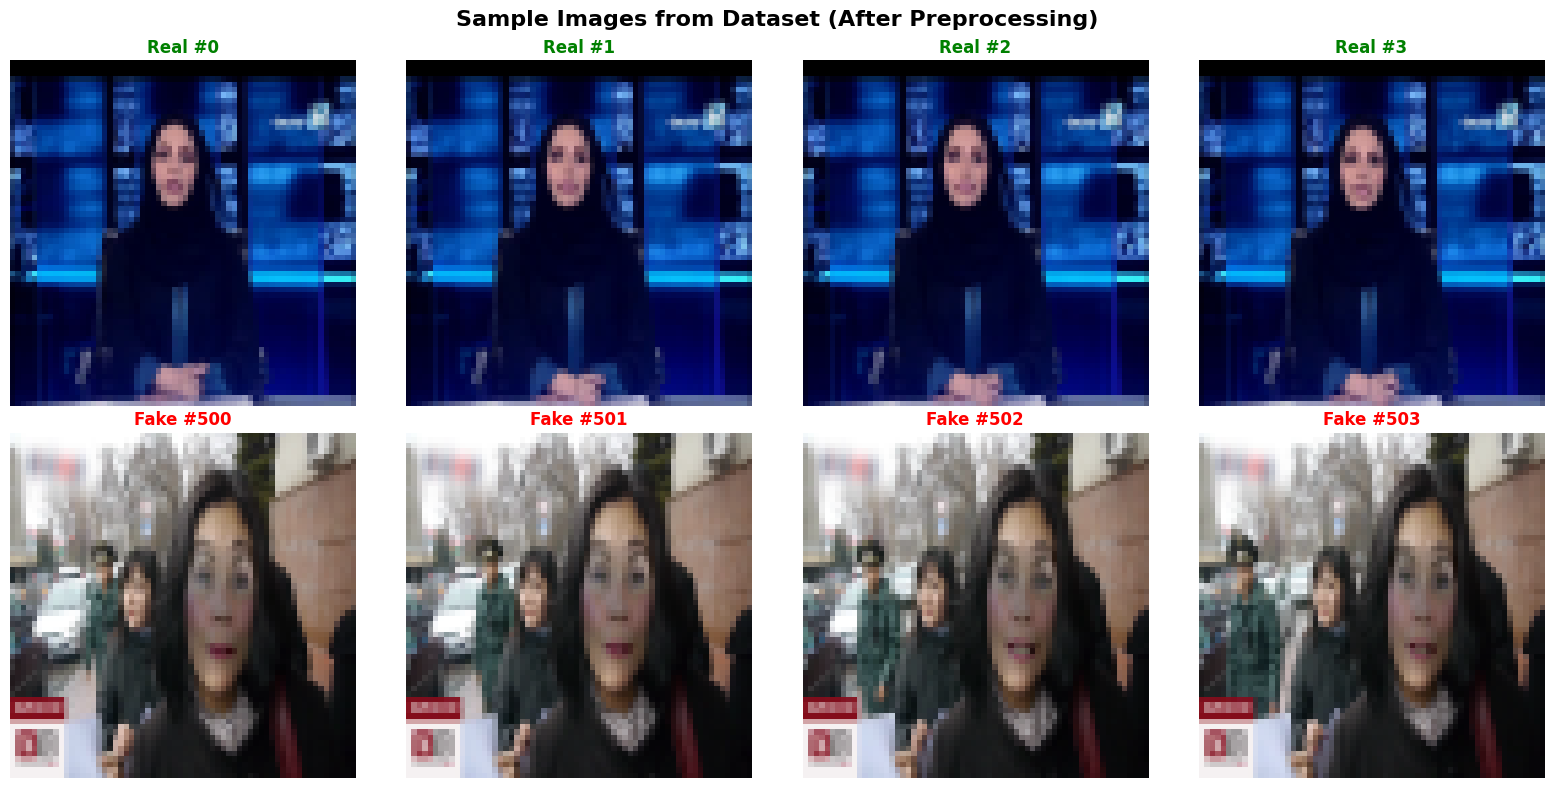

✅ Displayed 4 real and 4 fake sample images

💡 Image properties:
   • Resolution: 64×64 pixels
   • Normalized: Yes ([0, 1] range)
   • Format: RGB (3 channels)


In [25]:
print("\n🖼️ VISUALIZING SAMPLE IMAGES")
print("="*60)

import matplotlib.pyplot as plt

# Select random samples to visualize
num_samples = 8  # 4 real + 4 fake
real_indices = torch.where(y == 0)[0][:4]  # First 4 real images
fake_indices = torch.where(y == 1)[0][:4]  # First 4 fake images

# Create visualization
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Sample Images from Dataset (After Preprocessing)', fontsize=16, fontweight='bold')

# Plot real images (top row)
for i, idx in enumerate(real_indices):
    img = X[idx]  # Shape: (3, 64, 64)

    # Convert from (C, H, W) to (H, W, C) for matplotlib
    img_hwc = img.permute(1, 2, 0)  # Now shape: (64, 64, 3)

    # Display
    axes[0, i].imshow(img_hwc)
    axes[0, i].set_title(f'Real #{idx}', color='green', fontweight='bold')
    axes[0, i].axis('off')

# Plot fake images (bottom row)
for i, idx in enumerate(fake_indices):
    img = X[idx]  # Shape: (3, 64, 64)

    # Convert from (C, H, W) to (H, W, C) for matplotlib
    img_hwc = img.permute(1, 2, 0)  # Now shape: (64, 64, 3)

    # Display
    axes[1, i].imshow(img_hwc)
    axes[1, i].set_title(f'Fake #{idx}', color='red', fontweight='bold')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print(f"✅ Displayed 4 real and 4 fake sample images")
print(f"\n💡 Image properties:")
print(f"   • Resolution: 64×64 pixels")
print(f"   • Normalized: Yes ([0, 1] range)")
print(f"   • Format: RGB (3 channels)")

## Cell 5.4: Create Statistics Dictionary


In [26]:
# Create comprehensive statistics dictionary
dataset_stats = {
    # Dataset info
    'total_samples': X.shape[0],
    'num_real': (y == 0).sum().item(),
    'num_fake': (y == 1).sum().item(),

    # Image properties
    'image_shape': list(X.shape[1:]),  # [3, 64, 64]
    'image_size': CONFIG['image_size'],
    'num_channels': X.shape[1],

    # Value ranges
    'normalized': True,
    'value_range': [0.0, 1.0],
    'actual_min': X.min().item(),
    'actual_max': X.max().item(),

    # Per-channel statistics
    'channel_mean': mean.tolist(),  # Convert tensor to list
    'channel_std': std.tolist(),

    # Data types
    'X_dtype': str(X.dtype),
    'y_dtype': str(y.dtype),

    # Labels
    'label_mapping': {
        'real': CONFIG['label_real'],
        'fake': CONFIG['label_fake']
    },

    # Memory
    'X_memory_mb': (X.element_size() * X.nelement()) / (1024**2),
    'y_memory_mb': (y.element_size() * y.nelement()) / (1024**2),

    # Quality checks
    'is_contiguous': X.is_contiguous(),
    'has_nan': torch.isnan(X).any().item(),
    'has_inf': torch.isinf(X).any().item(),
}

# Print summary
print("\n📊 Dataset Metadata Summary:")
print("-"*60)
for key, value in dataset_stats.items():
    if isinstance(value, float):
        print(f"   {key}: {value:.6f}")
    elif isinstance(value, list) and len(value) <= 5:
        print(f"   {key}: {value}")
    elif isinstance(value, dict):
        print(f"   {key}:")
        for k, v in value.items():
            print(f"      {k}: {v}")
    else:
        print(f"   {key}: {value}")


📊 Dataset Metadata Summary:
------------------------------------------------------------
   total_samples: 1000
   num_real: 500
   num_fake: 500
   image_shape: [3, 64, 64]
   image_size: 64
   num_channels: 3
   normalized: True
   value_range: [0.0, 1.0]
   actual_min: 0.000000
   actual_max: 1.000000
   channel_mean: [0.35651838779449463, 0.3281535804271698, 0.35882750153541565]
   channel_std: [0.2900196313858032, 0.2744791507720947, 0.27654290199279785]
   X_dtype: torch.float32
   y_dtype: torch.int64
   label_mapping:
      real: 0
      fake: 1
   X_memory_mb: 46.875000
   y_memory_mb: 0.007629
   is_contiguous: True
   has_nan: False
   has_inf: False

✅ Metadata created successfully!


---

# SECTION 6: Save, Compress & Download

## Cell 6.1: Save Tensors to Disk

In [27]:
# Define filenames
filename_X = "FaceForensics_X.pt"
filename_y = "FaceForensics_y.pt"
filename_stats = "FaceForensics_stats.pt"

# Save X tensor (images)
print(f"\n📦 Saving X tensor to {filename_X}...")
torch.save(X, filename_X)
file_size_X = os.path.getsize(filename_X) / (1024**2)
print(f"✅ Saved! Size: {file_size_X:.2f} MB")

# Save y tensor (labels)
print(f"\n📦 Saving y tensor to {filename_y}...")
torch.save(y, filename_y)
file_size_y = os.path.getsize(filename_y) / (1024**2)
print(f"✅ Saved! Size: {file_size_y:.2f} MB")

# Save statistics
print(f"\n📦 Saving statistics to {filename_stats}...")
stats_to_save = {
    'mean': mean,           # Per-channel mean
    'std': std,             # Per-channel std
    'metadata': dataset_stats  # All other metadata
}
torch.save(stats_to_save, filename_stats)
file_size_stats = os.path.getsize(filename_stats) / (1024**2)
print(f"✅ Saved! Size: {file_size_stats:.2f} MB")

# Summary
total_size = file_size_X + file_size_y + file_size_stats
print(f"\n📊 Save Summary:")
print(f"   {filename_X}: {file_size_X:.2f} MB")
print(f"   {filename_y}: {file_size_y:.2f} MB")
print(f"   {filename_stats}: {file_size_stats:.2f} MB")
print(f"   Total: {total_size:.2f} MB")

print(f"\n✅ All tensors saved successfully!")


📦 Saving X tensor to FaceForensics_X.pt...
✅ Saved! Size: 46.88 MB

📦 Saving y tensor to FaceForensics_y.pt...
✅ Saved! Size: 0.01 MB

📦 Saving statistics to FaceForensics_stats.pt...
✅ Saved! Size: 0.00 MB

📊 Save Summary:
   FaceForensics_X.pt: 46.88 MB
   FaceForensics_y.pt: 0.01 MB
   FaceForensics_stats.pt: 0.00 MB
   Total: 46.89 MB

✅ All tensors saved successfully!


torch.save():

torch.save(X, filename_X) - Saves PyTorch tensor to disk

Serializes the tensor (converts to bytes)
Writes to a .pt file
Includes all metadata (shape, dtype, etc.)
Uses PyTorch's efficient binary format



File size calculation:

os.path.getsize(filename_X) - Gets file size in bytes
/ (1024**2) - Converts bytes to megabytes (MB)

Stats dictionary:

Combines mean, std, and metadata into one file
Your teammates load this one file to get all info

1. This is Colab's TEMPORARY storage

⚠️ NOT in Google Drive (unless you mounted Drive and changed directory)
⚠️ Will be deleted when Colab session ends
⚠️ Temporary workspace that resets

2. That's why we compress and download immediately

Cell 6.3 creates the zip in /content/faceforensics_dataset.zip
Cell 6.4 downloads it to your PC
After download, you have it permanently on your computer

## Cell 6.2: Verify Saved Files (Quality Check)


In [28]:
print("\n📋 Checking if files exist...")

# Check if all files were created
files_to_check = [filename_X, filename_y, filename_stats]
all_exist = True

for filename in files_to_check:
    exists = os.path.exists(filename)
    size_mb = os.path.getsize(filename) / (1024**2) if exists else 0
    status = "✅" if exists else "❌"
    print(f"   {status} {filename}: {size_mb:.2f} MB")
    all_exist = all_exist and exists

if all_exist:
    print(f"\n✅ All files exist!")
else:
    print(f"\n❌ Some files are missing!")
    raise FileNotFoundError("Not all files were saved correctly!")

# Load and verify one file to ensure it saved correctly
print(f"\n🔬 Testing file integrity (loading X tensor back)...")
X_loaded = torch.load(filename_X)

# Verify it matches the original
print(f"   Original shape: {X.shape}")
print(f"   Loaded shape: {X_loaded.shape}")
assert X.shape == X_loaded.shape, "❌ Shape mismatch!"

print(f"   Original dtype: {X.dtype}")
print(f"   Loaded dtype: {X_loaded.dtype}")
assert X.dtype == X_loaded.dtype, "❌ Dtype mismatch!"

# Check if tensors are identical
tensors_match = torch.equal(X, X_loaded)
print(f"   Tensors identical: {tensors_match}")
assert tensors_match, "❌ Tensors don't match!"

print(f"\n✅ File integrity verified! Saved files are valid.")

# Clean up the loaded tensor to free memory
del X_loaded


📋 Checking if files exist...
   ✅ FaceForensics_X.pt: 46.88 MB
   ✅ FaceForensics_y.pt: 0.01 MB
   ✅ FaceForensics_stats.pt: 0.00 MB

✅ All files exist!

🔬 Testing file integrity (loading X tensor back)...
   Original shape: torch.Size([1000, 3, 64, 64])
   Loaded shape: torch.Size([1000, 3, 64, 64])
   Original dtype: torch.float32
   Loaded dtype: torch.float32
   Tensors identical: True

✅ File integrity verified! Saved files are valid.


File existence check:

os.path.exists(filename) - Returns True if file exists
Verifies all three files were actually created

Integrity test:

torch.load(filename_X) - Loads the saved tensor back
Reads the .pt file and reconstructs the tensor
Should be identical to original

Verification:

torch.equal(X, X_loaded) - Checks if tensors are exactly identical

Compares every single element
Returns True only if perfectly identical
This proves no corruption during save



Why this matters:

Confirms the save operation worked correctly
Catches any disk errors or corruption
Gives you confidence before compressing

## Cell 6.3: Compress Files into ZIP


In [29]:
import zipfile
import time

# Define zip filename
zip_filename = "faceforensics_dataset.zip"

print(f"\n🗜️ Creating {zip_filename}...")
print(f"   This may take a moment...")

start_time = time.time()

# Create zip file
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add each file to the zip
    for filename in files_to_check:
        print(f"   📄 Adding {filename}...")
        zipf.write(filename, arcname=filename)

compression_time = time.time() - start_time

print(f"\n✅ Compression complete in {compression_time:.2f} seconds!")

# Check sizes
original_total_size = sum(os.path.getsize(f) for f in files_to_check) / (1024**2)
compressed_size = os.path.getsize(zip_filename) / (1024**2)
compression_ratio = (1 - compressed_size / original_total_size) * 100

print(f"\n📊 Compression Summary:")
print(f"   Original size: {original_total_size:.2f} MB")
print(f"   Compressed size: {compressed_size:.2f} MB")
print(f"   Space saved: {compression_ratio:.1f}%")
print(f"   Compression ratio: {compressed_size / original_total_size:.2f}x")

print(f"\n💡 Note: Compression is LOSSLESS - no quality loss!")


🗜️ Creating faceforensics_dataset.zip...
   This may take a moment...
   📄 Adding FaceForensics_X.pt...
   📄 Adding FaceForensics_y.pt...
   📄 Adding FaceForensics_stats.pt...

✅ Compression complete in 4.11 seconds!

📊 Compression Summary:
   Original size: 46.89 MB
   Compressed size: 13.76 MB
   Space saved: 70.6%
   Compression ratio: 0.29x

💡 Note: Compression is LOSSLESS - no quality loss!


zipfile.ZipFile():

zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) - Creates a zip file

'w' = write mode (create new zip)
zipfile.ZIP_DEFLATED = use DEFLATE compression algorithm (standard ZIP compression)
Returns a file handle we can add files to



Adding files:

zipf.write(filename, arcname=filename) - Adds a file to the zip

filename = path to the file on disk
arcname = name of the file inside the zip (same as original)
Compresses the file as it adds it



Context manager (with):

with zipfile.ZipFile(...) as zipf: - Automatically closes the zip when done
Ensures zip file is properly finalized
Even if errors occur, file is closed safely

Compression statistics:

Original size - sum of all three .pt files
Compressed size - size of the .zip file
Compression ratio = how much smaller (e.g., 0.85x = 15% saved)

## Cell 6.4: Download the ZIP File


In [31]:
from google.colab import files

print(f"\n📥 Initiating download of {zip_filename}...")
print(f"   Size: {compressed_size:.2f} MB")
print(f"   This will download to your browser's download folder")
print(f"\n   ⏳ Please wait, do not close this tab...")

# Download the zip file
files.download(zip_filename)

print(f"\n✅ Download initiated!")
print(f"\n📝 Next steps:")
print(f"   1. Check your browser's download folder")
print(f"   2. Locate: {zip_filename}")
print(f"   3. Extract the zip file")
print(f"   4. You'll find:")
print(f"      • your_dataset_X.pt (images)")
print(f"      • your_dataset_y.pt (labels)")
print(f"      • your_dataset_stats.pt (statistics)")


📥 Initiating download of faceforensics_dataset.zip...
   Size: 13.76 MB
   This will download to your browser's download folder

   ⏳ Please wait, do not close this tab...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download initiated!

📝 Next steps:
   1. Check your browser's download folder
   2. Locate: faceforensics_dataset.zip
   3. Extract the zip file
   4. You'll find:
      • your_dataset_X.pt (images)
      • your_dataset_y.pt (labels)
      • your_dataset_stats.pt (statistics)


files.download():

files.download(zip_filename) - Triggers browser download

Opens browser download dialog
Downloads file from Colab to your PC
Goes to your default downloads folder



Important notes:

This triggers immediately when cell runs
Browser will show download progress
Don't close the Colab tab until download completes!

## Cell 6.7: Optional Cleanup


In [32]:
print("Run this cell if you want to free up Colab disk space")
print("(Only needed if running low on space)")

# Delete individual .pt files (we have the zip)
print(f"\n🗑️ Deleting individual .pt files...")
for filename in files_to_check:
    if os.path.exists(filename):
        os.remove(filename)
        print(f"   Deleted: {filename}")

# Delete extracted frames
print(f"\n🗑️ Clearing extracted frames from memory...")
del original_frames
del deepfake_frames
del original_frames_resized
del deepfake_frames_resized
del original_frames_normalized
del deepfake_frames_normalized
del original_tensors
del deepfake_tensors
del X_original
del X_deepfake

print(f"\n✅ Cleanup complete!")
print(f"💾 Freed up ~{total_size * 2:.2f} MB of space")

Run this cell if you want to free up Colab disk space
(Only needed if running low on space)

🗑️ Deleting individual .pt files...
   Deleted: FaceForensics_X.pt
   Deleted: FaceForensics_y.pt
   Deleted: FaceForensics_stats.pt

🗑️ Clearing extracted frames from memory...

✅ Cleanup complete!
💾 Freed up ~93.78 MB of space
